# This note book is for build a CNN model to detect whether there a smoke on satellite images.

## Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns

from keras.applications.vgg16 import VGG16
from keras import optimizers
from tensorflow.keras.layers import Dense
import pathlib

The number of all images is 392
Total smoke images: 256 
 Total non-smoke images: 136


Text(0.5, 0, 'All classes')

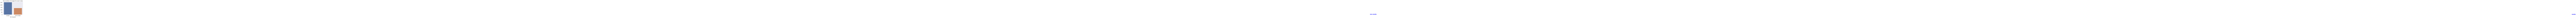

In [2]:
data_dir = pathlib.Path("/content/drive/MyDrive/images")
image_count = len(list(data_dir.glob('*/*.jp*g')))
print('The number of all images is',image_count)

smoke_count = len(list(pathlib.Path("/content/drive/MyDrive/images/haze").glob('*.jp*g')))
false_smoke_count = len(list(pathlib.Path("/content/drive/MyDrive/images/others").glob('*.jp*g')))
print('Total smoke images:',smoke_count,'\n','Total non-smoke images:',false_smoke_count)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots()
sns.barplot(y=[smoke_count,false_smoke_count], x=["smoke","non-smoke"], ax=ax)
for i, v in enumerate([smoke_count,false_smoke_count]):
  ax.text(v , i , ["smoke","non-smoke"][i], color='blue', fontweight='bold')

ax.set_title("the number of images for each class")
ax.set_xlabel("All classes")

In [3]:

batch_size = 16
img_height = 1024
img_width = 1024
color_mode = "rgb"
img_depth = 3
if (color_mode == "grayscale"):
    img_depth = 1

In [4]:
# split into training/validation sets (80/20 split)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=2020,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=2020,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode)
# print class names - should be 'haze' and 'others'
class_names = train_ds.class_names
print(class_names)

Found 392 files belonging to 2 classes.
Using 314 files for training.
Found 392 files belonging to 2 classes.
Using 78 files for validation.
['haze', 'others']


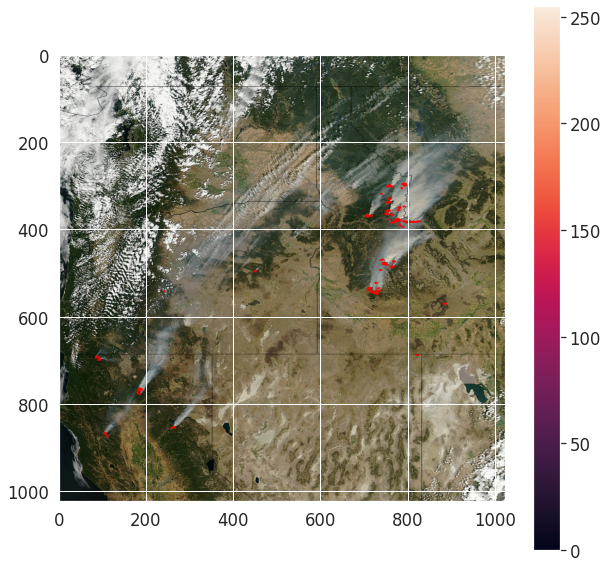

In [5]:
# display one image with colorbar
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(1):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.colorbar()
        plt.grid = False

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, img_depth)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

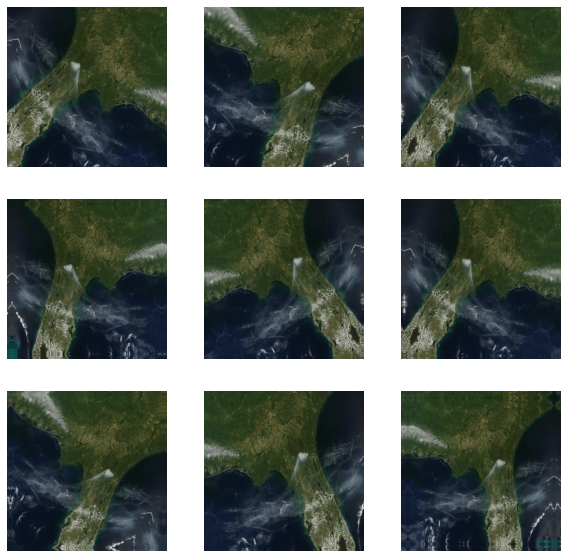

In [7]:
# visualize a few augmented examples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## ConvNet model tries

In [8]:
num_classes = 2
dropout = 0.2

In [9]:
#model without augmantation

model = Sequential([
	  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, img_depth)),
	  layers.Conv2D(16, 3, padding='same', activation='relu'),
	  layers.MaxPooling2D(),
	  layers.Conv2D(32, 3, padding='same', activation='relu'),
	  layers.MaxPooling2D(),
	  layers.Conv2D(64, 3, padding='same', activation='relu'),
	  layers.MaxPooling2D(),
	  layers.Dropout(dropout),
	  layers.Flatten(),
	  layers.Dense(128, activation='relu'),
	  layers.Dense(num_classes)
	])


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 1024, 1024, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 1024, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)     

In [11]:

# train the model
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 11s 564ms/step - loss: 4.7981 - accuracy: 0.5955 - val_loss: 0.6535 - val_accuracy: 0.6923
Epoch 2/30
20/20 [==============================] - 2s 121ms/step - loss: 0.6680 - accuracy: 0.6433 - val_loss: 0.6380 - val_accuracy: 0.6923
Epoch 3/30
20/20 [==============================] - 2s 121ms/step - loss: 0.6207 - accuracy: 0.6656 - val_loss: 0.6059 - val_accuracy: 0.6795
Epoch 4/30
20/20 [==============================] - 2s 121ms/step - loss: 0.5569 - accuracy: 0.7102 - val_loss: 0.5091 - val_accuracy: 0.7949
Epoch 5/30
20/20 [==============================] - 2s 121ms/step - loss: 0.3967 - accuracy: 0.8153 - val_loss: 0.6011 - val_accuracy: 0.7564
Epoch 6/30
20/20 [==============================] - 2s 121ms/step - loss: 0.3187 - accuracy: 0.8535 - val_loss: 0.4887 - val_accuracy: 0.8205
Epoch 7/30
20/20 [==============================] - 2s 122ms/step - loss: 0.1762 - accuracy: 0.9268 - val_loss: 0.6299 - val_accuracy: 0.8205
Epoch

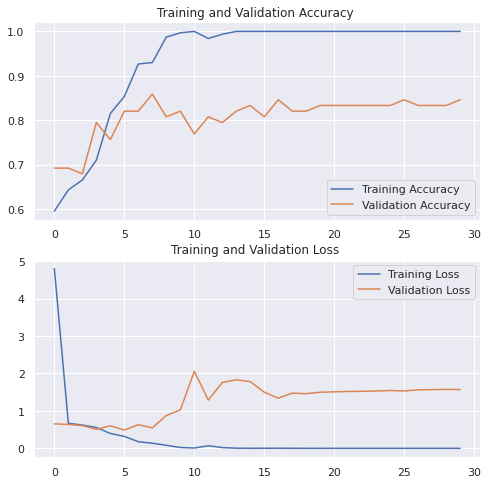

In [12]:
# create plots of in-sample error and validation error
sns.set(font_scale=1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
title = 'Training and Validation Accuracy '

plt.title(title)

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
title = 'Training and Validation Loss '
plt.title(title)
plt.show()

In [13]:
#model with augmantation
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, img_depth, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, img_depth, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, img_depth, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 3s 152ms/step - loss: 8.6741 - accuracy: 0.5287 - val_loss: 0.6177 - val_accuracy: 0.7179
Epoch 2/30
20/20 [==============================] - 3s 146ms/step - loss: 0.6122 - accuracy: 0.6847 - val_loss: 0.5733 - val_accuracy: 0.7692
Epoch 3/30
20/20 [==============================] - 3s 146ms/step - loss: 0.6231 - accuracy: 0.7325 - val_loss: 0.5769 - val_accuracy: 0.8205
Epoch 4/30
20/20 [==============================] - 3s 146ms/step - loss: 0.5789 - accuracy: 0.7134 - val_loss: 0.4639 - val_accuracy: 0.8462
Epoch 5/30
20/20 [==============================] - 3s 148ms/step - loss: 0.5142 - accuracy: 0.7580 - val_loss: 0.4987 - val_accuracy: 0.8077
Epoch 6/30
20/20 [==============================] - 3s 153ms/step - loss: 0.5188 - accuracy: 0.7548 - val_loss: 0.7233 - val_accuracy: 0.6923
Epoch 7/30
20/20 [==============================] - 3s 146ms/step - loss: 0.4190 - accuracy: 0.8025 - val_loss: 0.3931 - val_accuracy: 0.8333
Epoch 

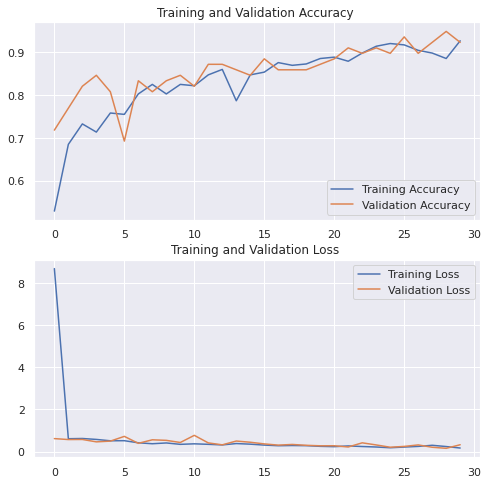

In [14]:
# create plots of in-sample error and validation error
sns.set(font_scale=1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
title = 'Training and Validation Accuracy '

plt.title(title)

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
title = 'Training and Validation Loss '
plt.title(title)
plt.show()

## Inception resnet v2 tries


In [50]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=2020,
    image_size=(299, 299),
    batch_size=batch_size,
    color_mode=color_mode)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=2020,
    image_size=(299, 299),
    batch_size=batch_size,
    color_mode=color_mode)
# print class names - should be 'haze' and 'others'
class_names = train_ds.class_names
print(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 392 files belonging to 2 classes.
Using 314 files for training.
Found 392 files belonging to 2 classes.
Using 78 files for validation.
['haze', 'others']


In [51]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [52]:
incmodel=InceptionResNetV2()
incmodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_209[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [53]:
incmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
epochs=20
history = incmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
20/20 [==============================] - 14s 675ms/step - loss: 6.4188 - accuracy: 0.5796 - val_loss: 6.8487 - val_accuracy: 0.0513
Epoch 2/20
20/20 [==============================] - 4s 205ms/step - loss: 6.0872 - accuracy: 0.8280 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 3/20
20/20 [==============================] - 4s 205ms/step - loss: 6.0236 - accuracy: 0.8949 - val_loss: 6.6018 - val_accuracy: 0.3077
Epoch 4/20
20/20 [==============================] - 4s 205ms/step - loss: 5.9381 - accuracy: 0.9777 - val_loss: 6.6018 - val_accuracy: 0.3077
Epoch 5/20
20/20 [==============================] - 4s 205ms/step - loss: 5.9442 - accuracy: 0.9650 - val_loss: 6.2213 - val_accuracy: 0.6923
Epoch 6/20
20/20 [==============================] - 4s 205ms/step - loss: 5.9469 - accuracy: 0.9650 - val_loss: 6.4866 - val_accuracy: 0.4487
Epoch 7/20
20/20 [==============================] - 4s 206ms/step - loss: 5.9513 - accuracy: 0.9618 - val_loss: 6.2912 - val_accuracy: 0.6410
Epoch

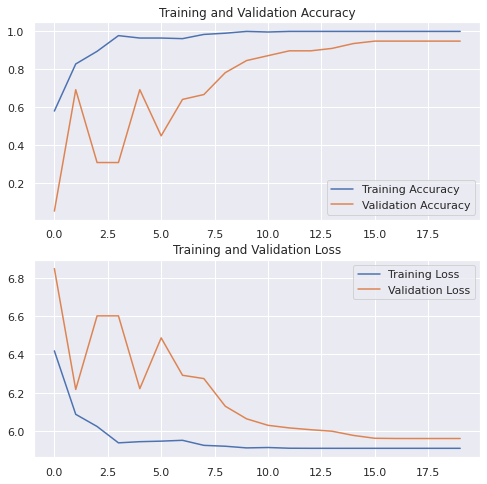

In [55]:
# create plots of in-sample error and validation error
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
title = 'Training and Validation Accuracy'

plt.title(title)

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
title = 'Training and Validation Loss'
plt.title(title)
plt.show()

In [45]:
incmodel.predict(val_ds)

array([[1.00000000e+00, 3.83682842e-12, 2.19546133e-15, ...,
        7.37252903e-15, 2.51771374e-15, 1.36213253e-15],
       [2.35220562e-13, 1.00000000e+00, 1.13837241e-17, ...,
        2.95919542e-18, 4.78618581e-17, 3.86342414e-17],
       [1.25149003e-04, 9.99874353e-01, 3.54020924e-10, ...,
        2.09828072e-10, 8.70159500e-10, 5.69315373e-10],
       ...,
       [9.99999404e-01, 6.23824917e-07, 1.57052791e-11, ...,
        2.42724868e-11, 1.61077662e-11, 1.17579314e-11],
       [1.00000000e+00, 6.37323483e-09, 4.17583849e-12, ...,
        8.43470172e-12, 5.13560505e-12, 2.75867133e-12],
       [9.99999881e-01, 6.34127559e-08, 3.54819646e-11, ...,
        5.18936907e-11, 4.07990065e-11, 2.21153287e-11]], dtype=float32)

## VGG 16 tries

In [21]:
from keras.models import Model

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=2020,
    image_size=(224, 224),
    batch_size=batch_size,
    color_mode=color_mode)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=2020,
    image_size=(224, 224),
    batch_size=batch_size,
    color_mode=color_mode)
# print class names - should be 'haze' and 'others'
class_names = train_ds.class_names
print(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 392 files belonging to 2 classes.
Using 314 files for training.
Found 392 files belonging to 2 classes.
Using 78 files for validation.
['haze', 'others']


In [39]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:19]:
    layers.trainable = False

In [40]:
X= vggmodel.layers[-2].output

predictions = Dense(2, activation="softmax")(X)

#model_final = Model(input = vggmodel.input, output = predictions)

vggmodel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = 'adam', 
              metrics=["accuracy"])

In [41]:

epochs=20
history = vggmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
20/20 [==============================] - 1s 40ms/step - loss: 6.3346 - accuracy: 0.5732 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 6.2662 - accuracy: 0.6433 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 3/20
20/20 [==============================] - 1s 32ms/step - loss: 6.2662 - accuracy: 0.6433 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 4/20
20/20 [==============================] - 1s 32ms/step - loss: 6.2662 - accuracy: 0.6433 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 6.2662 - accuracy: 0.6433 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 6/20
20/20 [==============================] - 1s 32ms/step - loss: 6.2662 - accuracy: 0.6433 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 7/20
20/20 [==============================] - 1s 32ms/step - loss: 6.2662 - accuracy: 0.6433 - val_loss: 6.2172 - val_accuracy: 0.6923
Epoch 8/20
20

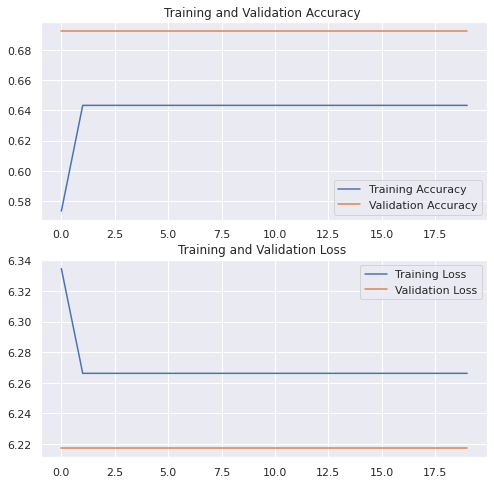

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
title = 'Training and Validation Accuracy '

plt.title(title)

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
title = 'Training and Validation Loss '
plt.title(title)
plt.show()

## Alexnet tries

In [18]:
# split into training/validation sets (80/20 split)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=2020,
    image_size=(224, 224),
    batch_size=batch_size,
    color_mode=color_mode)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=2020,
    image_size=(224, 224),
    batch_size=batch_size,
    color_mode=color_mode)
# print class names - should be 'haze' and 'others'
class_names = train_ds.class_names
print(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 392 files belonging to 2 classes.
Using 314 files for training.
Found 392 files belonging to 2 classes.
Using 78 files for validation.
['haze', 'others']


In [19]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

In [24]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(17))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
#
#loss=keras.losses.binary_crossentropy

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## SPP tries


In [ ]:
!pip install git+git://github.com/yhenon/keras-spp.git

In [ ]:
import keras

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dense
from spp.SpatialPyramidPooling import SpatialPyramidPooling

In [ ]:

# train on 64x64x3 images
model.fit(np.random.rand(batch_size, num_channels, 64, 64), np.zeros((batch_size, num_classes)))
# train on 32x32x3 images
model.fit(np.random.rand(batch_size, num_channels, 32, 32), np.zeros((batch_size, num_classes)))

In [ ]:
batch_size = 64
num_channels = 3
num_classes = 10

model = Sequential()

# uses theano ordering. Note that we leave the image size as None to allow multiple image sizes
model.add(Convolution2D(32, 3, 3, padding='same', input_shape=( None, None,3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(SpatialPyramidPooling([1, 2, 4]))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='sgd')


AttributeError: ignored

In [ ]:
help(Conv2D)